# Modelos de Regresión y Clasificación II
Actividad Lección 5 || Fundamentos de IA y Machine Learning

Objetivos:
* Aplicar conceptos teóricos vistos en clase

Datos del alumno:
* Víctor Luque Martín
* Máster Avanzado en Programación en Python para Hacking, BigData y Machine Learning

Fecha: 29/10/2022

# Tabla de contenidos
1. [Preparación Previa](#pp)
    1. [Importar librerías](#pp-importar)
    2. [Distancia Euclídea](#pp-distancia)
    3. [Función para calcular el número de vecinos más cercanos](#pp-vecinos)
2. [Problema I](#p1)
    1. [Carga de datos](#p1-carga-datos)
    2. [Representación de los datos](#p1-representacion)
    3. [Algoritmo de agrupamiento k-medias](#p1-algoritmo)
    4. [Evolución de los centroides](#p1-evolucion)
    5. [Resultados](#p1-resultados)
    6. [Métrica SSE](#p1-metrica)
3. [Problema II](#p2)
    1. [Algoritmo de clustering jerárquico](#p2-algoritmo)
    2. [Resultados enlace simple](#p2-simple)
    3. [Resultados enlace completo](#p2-completo)
    4. [Enlace medio](#p2-medio)
4. [Problema III](#p3)
    1. [Carga de datos](#p3-carga-datos)
    2. [Algoritmo DBSCAN](#p3-dbscan)
    3. [Resultados DBSCAN con 𝑀 = 3 y ϵ = $\sqrt{2}$](#p3-dbscan-1)
    4. [Resultados DBSCAN con 𝑀 = 3 y ϵ = $\sqrt{10}$](#p3-dbscan-2)
    5. [Representación de los resultados](#p3-representacion)
    6. [¿En qué afecta el cambio del parámetro ϵ?](#p3-epsilon)

# Prepación Previa <a class="anchor" name="pp"></a>
- Importar librerías
- Definir función distancia euclídea

## Importar librerías <a class="anchor" name="pp-importar"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Distancia euclídea <a class="anchor" name="pp-distancia"></a>
Es la raíz cuadrada de las diferencias al cuadrado de cada una de las coordenadas de los puntos.

$$d_E(X_1,X_2) = \sqrt{\sum_{i=1}^{k} (X_{1i} - X_{2i})^2}$$

In [2]:
def distancia_euclidea(x1, x2):
    if len(x1) != len(x2):
        raise Exception("Las coordenadas deben tener la misma cantidad de elementos")
    k = len(x1)
    sumatorio = sum([(x1[i] - x2[i])**2 for i in range(k)])
    return sumatorio**0.5

## Función para calcular el número de vecinos más cercanos <a class="anchor" name="pp-vecinos"></a>
A partir de un conjunto de datos, un punto y un radio, devuelve los puntos que se encuentran dentro del radio. Se apoya en la función distancia euclídea para calcular la distancia entre el punto y los puntos del conjunto de datos.

In [3]:
def get_neighbors(df, point, eps):
    neighbours = []
    for i, row in df.iterrows():
        if distancia_euclidea(point, row[["coorX", "coorY"]]) <= eps:
            neighbours.append(i)
    return neighbours

# Problema I <a name="p1"></a>
Se pide agrupar un total de 8 patrones bidimensionales en tres clusters (𝑘 = 3). Los patrones son los siguientes: A1 (2,10), A2(2,5), A3(8,4), A4(5,8), A5(7,5),
A6(6,4), A7(1,2) y A8(4,9). Los centroides iniciales son los puntos A1, A3 y A4. La métrica de distancia utilizada será la distancia euclídea.
Se pide:
1. Representar los clusters creados y la posición de los centroides después de cada iteración.
2. El valor de la métrica SSE.
3. Comparar los resultados con los obtenidos en el ejemplo de la sección 2.3. del manual de la lección 5.
4. ¿Á que se debe la diferencia de resultados?

## Carga de datos <a class="anchor" name="p1-carga-datos"></a>
Se muestran de forma resaltada los puntos iniciales de los centroides (A1, A3, A4).

In [4]:
l5p1 = pd.read_csv("l5p1.csv")
l5p1

,coorX,coorY
0,2,10
1,2,5
2,8,4
3,5,8
4,7,5
5,6,4
6,1,2
7,4,9


## Representación de los datos <a class="anchor" name="p1-representacion"></a>
Los centroides vienen representados como puntos rojos

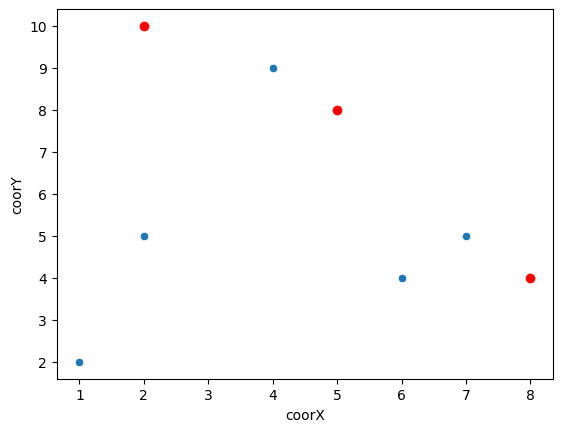

In [5]:
sns.scatterplot(x="coorX", y="coorY", data=l5p1)
# change color of points (2,10), (8,4), (5,8)
plt.scatter([2,8,5], [10,4,8], color="red")
plt.show()

## Algortimo de agrupamiento k-medias <a class="anchor" name="p1-algoritmo"></a>
En este algoritmo se asume que se conoce o se cree conocer el número de clusters 𝑘. Por tanto, dado un valor de 𝑘, la idea es encontrar la partición que optimice el criterio de particionamiento. Cada grupo tiene asociado un centroide y se busca que cada punto o patrón esté lo más cerca posible de su centroide, utilizando cualquier métrica de distancia. Iterativamente, se van actualizando estos centroides en función de las asignaciones de cada punto a los distintos grupos, proceso que se repite hasta que los centroides dejan de cambiar.

In [6]:
def kmedias(l5p1):
    # inicializar los centroides
    c1, c2, c3 = (2,10), (8,4), (5,8)
    cambio = True
    result_df: pd.DataFrame = l5p1.copy()
    check_df: pd.DataFrame = l5p1.copy()
    i = 0
    # Crea una figura para 4 iteraciones
    fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
    while cambio:
        # definir los clusters a partir de los centroides
        distances_df = pd.DataFrame({
            "C1": [distancia_euclidea(row[["coorX", "coorY"]], c1) for _, row in result_df.iterrows()],
            "C2": [distancia_euclidea(row[["coorX", "coorY"]], c2) for _, row in result_df.iterrows()],
            "C3": [distancia_euclidea(row[["coorX", "coorY"]], c3) for _, row in result_df.iterrows()],
        })
        # comprobación cambios en el cluster
        # en caso de no haber cambios entre iteraciones, se termina el algoritmo
        check_df["cluster"] = distances_df.idxmin(axis=1)
        if "cluster" in result_df.columns:
            cambio = not (result_df["cluster"] == check_df["cluster"]).all()
        # asignar los clusteres a los puntos
        result_df["cluster"] = distances_df.idxmin(axis=1)
        
        # plotear los puntos
        sns.scatterplot(x="coorX", y="coorY", hue="cluster", data=result_df, ax=ax[i])
        ax[i].scatter([c1[0],c2[0],c3[0]], [c1[1],c2[1],c3[1]], color=["blue", "green", "orange"], marker="x")
        ax[i].set_title(f"Iteración {i}")
        for j, txt in enumerate([c1, c2, c3]):
            ax[i].annotate(f"({round(txt[0], 2)}, {round(txt[1], 2)})", (txt[0]+0.1, txt[1]+0.1))
        # actualizar los centroides
        c1 = tuple(result_df[result_df["cluster"] == "C1"][["coorX", "coorY"]].mean().to_list())
        c2 = tuple(result_df[result_df["cluster"] == "C2"][["coorX", "coorY"]].mean().to_list())
        c3 = tuple(result_df[result_df["cluster"] == "C3"][["coorX", "coorY"]].mean().to_list())          
        i+=1
    plt.show()
    # Asignar coordenadas a los centroides
    result_df["centroid_x"] = result_df["cluster"].apply(
        lambda x: round(c1[0], 2) if x == "C1" else round(c2[0], 2) if x == "C2" else round(c3[0], 2))
    result_df["centroid_y"] = result_df["cluster"].apply(
        lambda x: round(c1[1], 2) if x == "C1" else round(c2[1], 2) if x == "C2" else round(c3[1], 2))
    return result_df

## Evolución de los centroides <a class="anchor" name="p1-evolucion"></a>
Al invocar a la función kmedias, se obtiene la evolución de los centroides en cada iteración.

Los centroides de cada cluster vienen representados con cruces (x)

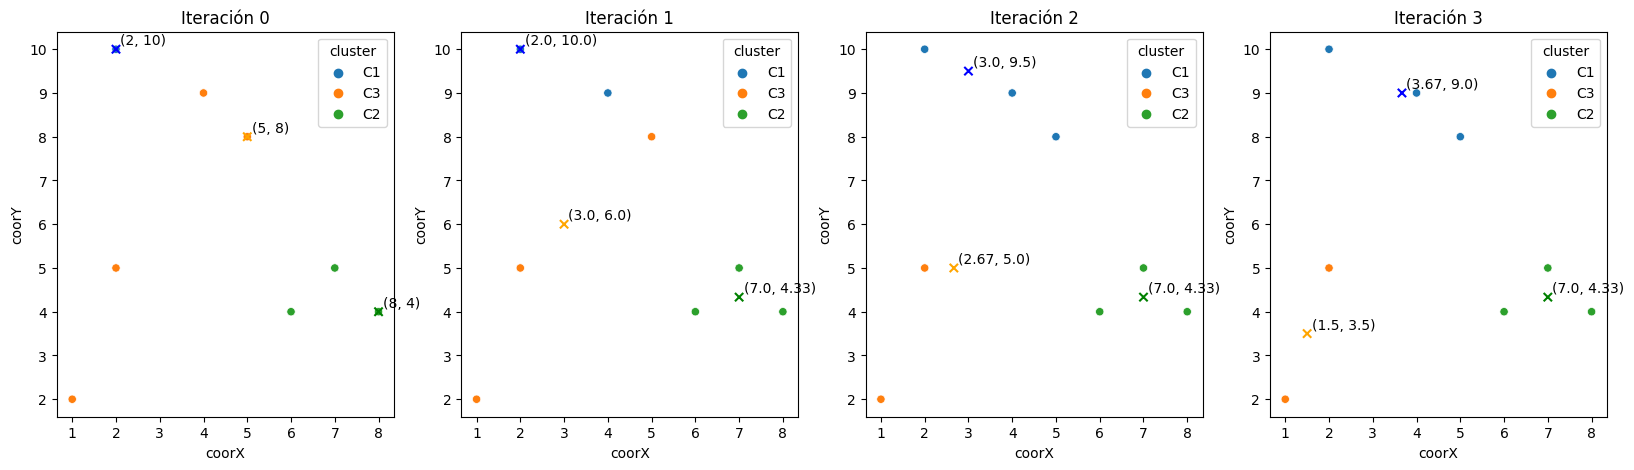

In [7]:
result_df = kmedias(l5p1)

## Resultados <a class="anchor" name="p1-resultados"></a>

In [8]:
# Asignar columna distancia al centroide
result_df["distancia_centroide"] = result_df.apply(lambda x: distancia_euclidea(
        (x["coorX"], x["coorY"]), (x["centroid_x"], x["centroid_y"])
    ), axis=1)
result_df

,coorX,coorY,cluster,centroid_x,centroid_y,distancia_centroide
0,2,10,C1,3.67,9.00,1.946510
1,2,5,C3,1.50,3.50,1.581139
2,8,4,C2,7.00,4.33,1.053043
3,5,8,C1,3.67,9.00,1.664001
4,7,5,C2,7.00,4.33,0.670000
5,6,4,C2,7.00,4.33,1.053043
6,1,2,C3,1.50,3.50,1.581139
7,4,9,C1,3.67,9.00,0.330000


## Métrica SSE <a class="anchor" name="p1-metrica"></a>
El SSE es la suma del error cuadrático de cada punto respecto a su centroide. Cuanto menor sea el SSE, mejor será la agrupación.

$$SSE = \sum_{i=1}^{n} (x_i - \mu_{x_i})^2$$

Siendo **$x_i$** un patrón y **$\mu_{xi}$** el centroide del cluster al que pertenece.

In [9]:
sse = 0
for i, row in result_df.iterrows():
    sse += row["distancia_centroide"]**2
print(f"Métrica SSE: {sse}")

Métrica SSE: 14.333400000000003


# Problema II <a name="p2"></a>
Dada la siguiente matriz de distancias entre cinco patrones:

In [10]:
l5p2_df = pd.DataFrame({
    "A" : [0, 1, 2, 9, 10],
    "B" : [1, 0, 3, 7, 5],
    "C" : [2, 3, 0, 4, 6],
    "D" : [9, 7, 4, 0, 8],
    "E" : [10, 5, 6, 8, 0],
}, index=["A", "B", "C", "D", "E"])
l5p2_df


,A,B,C,D,E
A,0,1,2,9,10
B,1,0,3,7,5
C,2,3,0,4,6
D,9,7,4,0,8
E,10,5,6,8,0


Se pide:
1. Aplicar un clustering jerárquico con el método de enlace simple.
2. Aplicar un clustering jerárquico con el método de enlace completo.
3. ¿Se podría usar el método de enlace medio con estos datos? Justifica la respuesta.

## Algoritmo de clustering jerárquico <a class="anchor" name="p2-algoritmo"></a>
Este tipo de clustering se basa en medir la distancia entre clusters. En función del tipo de enlace que se utilice, se medirá la distancia entre los puntos más cercanos, los más lejanos o la media de las distancias entre todos los puntos. El algoritmo se basa en ir uniendo los clusters más cercanos hasta que se obtiene un único cluster. Los enlaces que trabajaremos son:
* Enlace simple: distancia entre los puntos más cercanos de cada cluster.

$$D(C,C') = min_{x \in C, x' \in C'} d(x,x')$$

* Enlace completo: distancia entre los puntos más lejanos de cada cluster.

$$D(C,C') = max_{x \in C, x' \in C'} d(x,x')$$

* Enlace medio: distancia media entre todos los puntos de cada cluster.

$$D(C,C') = \frac{1}{|C| \cdot |C'|} \sum_{x \in C, x' \in C'} d(x,x')$$

In [11]:
def linkage(df, func):
    # Agrupar los clusteres dada una función de enlace
    merged = True
    result = {}
    while merged:
        merged = False
        dist = 100
        cluster = None
        for i, row in df.iterrows():
            for j, col in row.items():
                if i != j and col < dist:
                    dist = col
                    cluster = (i, j)
        if cluster:
            print(f"Merge ({', '.join(cluster)}) with distance {dist}")
            merged = True
            # Combinar los clusteres en función de la función de enlace
            df[cluster[0]] = df[cluster[0]].combine(df[cluster[1]], func)
            df[cluster[1]] = df[cluster[0]]
            # Eliminar la columna del cluster combinado
            df = df.drop(cluster[1], axis=1)
            df = df.drop(cluster[1], axis=0)
            # Reemplazar nombres de columnas y filas
            df = df.rename(
                columns={cluster[0]: f"{cluster[0]}{cluster[1]}"}, 
                index={cluster[0]: f"{cluster[0]}{cluster[1]}"}
            )
            print(f"Clusters {cluster[0]} y {cluster[1]} unidos")
            print(df)
            print("")
            result[''.join(cluster)] = dist
    return result

## Resultados enlace simple <a class="anchor" name="p2-simple"></a>

In [12]:
print(f"Dendograma Enlace Simple: {linkage(l5p2_df.copy(), min)}")

Merge (A, B) with distance 1
Clusters A y B unidos
    AB  C  D   E
AB   0  2  9  10
C    2  0  4   6
D    7  4  0   8
E    5  6  8   0

Merge (AB, C) with distance 2
Clusters AB y C unidos
     ABC  D   E
ABC    0  9  10
D      4  0   8
E      5  8   0

Merge (D, ABC) with distance 4
Clusters D y ABC unidos
      DABC  E
DABC     0  8
E        5  0

Merge (E, DABC) with distance 5
Clusters E y DABC unidos
       EDABC
EDABC      0

Dendograma Enlace Simple: {'AB': 1, 'ABC': 2, 'DABC': 4, 'EDABC': 5}


## Resultados enlace completo <a class="anchor" name="p2-completo"></a>

In [13]:
print(f"Dendograma Enlace Completo: {linkage(l5p2_df.copy(), max)}")

Merge (A, B) with distance 1
Clusters A y B unidos
    AB  C  D   E
AB   1  2  9  10
C    3  0  4   6
D    9  4  0   8
E   10  6  8   0

Merge (AB, C) with distance 2
Clusters AB y C unidos
     ABC  D   E
ABC    2  9  10
D      9  0   8
E     10  8   0

Merge (D, E) with distance 8
Clusters D y E unidos
     ABC  DE
ABC    2  10
DE     9   8

Merge (DE, ABC) with distance 9
Clusters DE y ABC unidos
       DEABC
DEABC      9

Dendograma Enlace Completo: {'AB': 1, 'ABC': 2, 'DE': 8, 'DEABC': 9}


## Enlace medio <a class="anchor" name="p2-medio"></a>
Para este set de datos no es posible aplicar el enlace medio, porque la matriz dada no contiene los puntos de cada cluster, sino las distancias entre ellos. Por tanto, no se puede calcular la distancia media entre todos los puntos de cada cluster.

# Problema III <a name="p3"></a>
Dados los mismos puntos del Problema I.
Se pide:
1. Aplicar DBSCAN considerando 𝑀 = 3 y ϵ = $\sqrt{2}$.
2. Aplicar DBSCAN considerando 𝑀 = 3 y ϵ = $\sqrt{10}$.
3. ¿En qué afecta el cambio del parámetro ϵ ?

## Carga de datos <a class="anchor" name="p3-carga-datos"></a>
Se utiliza una copia de los datos del problema I.

In [14]:
l5p3_df = l5p1.copy()
l5p3_df

,coorX,coorY
0,2,10
1,2,5
2,8,4
3,5,8
4,7,5
5,6,4
6,1,2
7,4,9


## Algoritmo DBSCAN <a class="anchor" name="p3-dbscan"></a>
El algoritmo DBSCAN se basa en dos parámetros: el número mínimo de puntos 𝑀 y el radio ϵ. El algoritmo DBSCAN busca los puntos que se encuentran dentro de un radio ϵ y que tienen al menos 𝑀 puntos dentro de ese radio. Estos puntos se denominan puntos centrales. A partir de estos puntos centrales, se busca los puntos que se encuentran dentro de un radio ϵ y que tienen al menos 𝑀 puntos dentro de ese radio. Estos puntos se denominan puntos frontera. Los puntos que no son ni centrales ni frontera se denominan puntos ruido.

In [15]:
def dbscan(df, m, epsilon):
    clusters = {}
    noise = []
    visited = []
    cluster_id = 0
    for i, row in df.iterrows():
        # Si el punto ya fue visitado, se salta
        if i not in visited:
            visited.append(i)
            # Se obtienen los puntos dentro del radio
            neighbors = get_neighbors(df, row, epsilon)
            # Si el punto no tiene suficientes vecinos, se considera ruido
            if len(neighbors) < m:
                noise.append(i)
            else:
                # Se crea un nuevo cluster
                cluster_id += 1
                clusters[cluster_id] = []
                # Se agrega el punto al cluster
                clusters[cluster_id].append(i)
                # Se agregan los vecinos al cluster
                for j in neighbors:
                    if j not in visited:
                        visited.append(j)
                        neighbors2 = get_neighbors(df, row, epsilon)
                        # Si el punto tiene suficientes vecinos, se agregan a los vecinos
                        if len(neighbors2) >= m:
                            neighbors += neighbors2
                    # Si el punto no pertenece a un cluster, se agrega al cluster actual
                    if j not in clusters[cluster_id]:
                        # Se agrega el punto al cluster
                        clusters[cluster_id].append(j)
    # Eliminar puntos del ruido que pertenecen a un cluster
    for i in noise:
        for j in clusters:
            if i in clusters[j]:
                noise.remove(i)

    # Agrupar puntos repetidos en clusters
    for i in clusters:
        for j in clusters:
            if i != j:
                if set(clusters[i]) & set(clusters[j]):
                    clusters[i] += clusters[j]
                    clusters[j] = []
    # Eliminación de clusters vacíos
    clusters = {k: v for k, v in clusters.items() if v}
    # Eliminación de puntos repetidos en clusters
    for i in clusters:
        clusters[i] = list(set(clusters[i]))
    return clusters, noise

## Resultados DBSCAN con 𝑀 = 3 y ϵ = $\sqrt{2}$ <a class="anchor" name="p3-dbscan-1"></a>

In [16]:
clusters_sqrt_2, noise_sqrt_2 = dbscan(l5p3_df, m=3, epsilon=2**0.5)
print(f"Clusters: {clusters_sqrt_2}")
print(f"Noise: {noise_sqrt_2}")

Clusters: {1: [2, 4, 5]}
Noise: [0, 1, 3, 6, 7]


## Resultados DBSCAN con 𝑀 = 3 y ϵ = $\sqrt{10}$ <a class="anchor" name="p3-dbscan-2"></a>

In [17]:
clusters_sqrt_10, noise_sqrt_10 = dbscan(l5p3_df, m=3, epsilon=10**0.5)
print(f"Clusters: {clusters_sqrt_10}")
print(f"Noise: {noise_sqrt_10}")

Clusters: {1: [2, 4, 5], 2: [0, 3, 7]}
Noise: [1, 6]


## Representación de los datos <a class="anchor" name="p3-representacion"></a>

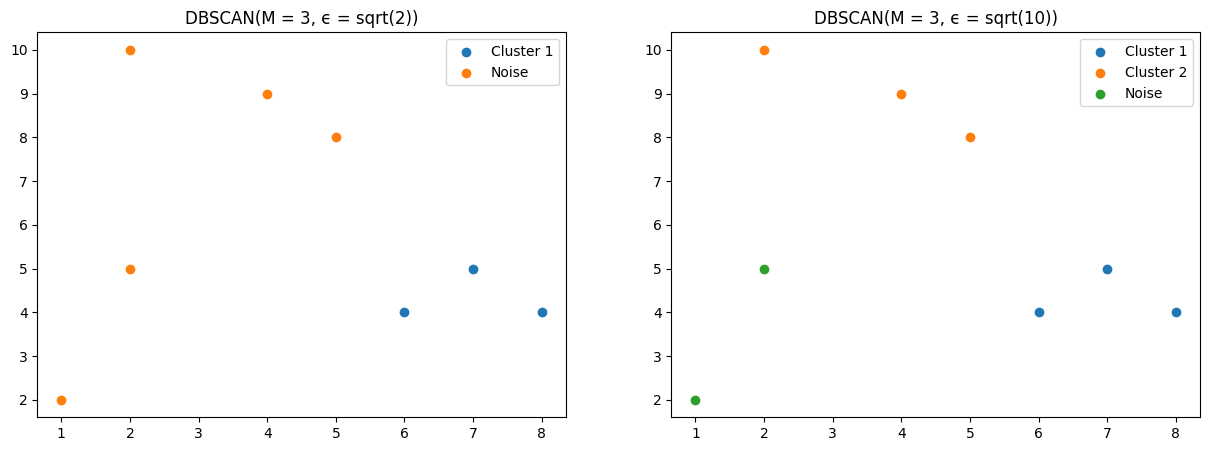

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("DBSCAN(M = 3, ϵ = sqrt(2))")
ax[1].set_title("DBSCAN(M = 3, ϵ = sqrt(10))")
for i in clusters_sqrt_2:
    ax[0].scatter(
        l5p3_df.iloc[clusters_sqrt_2[i]]["coorX"], 
        l5p3_df.iloc[clusters_sqrt_2[i]]["coorY"], 
        label=f"Cluster {i}"
)
ax[0].scatter(
    l5p3_df.iloc[noise_sqrt_2]["coorX"], 
    l5p3_df.iloc[noise_sqrt_2]["coorY"], 
    label="Noise"
)
ax[0].legend()
for i in clusters_sqrt_10:
    ax[1].scatter(
        l5p3_df.iloc[clusters_sqrt_10[i]]["coorX"], 
        l5p3_df.iloc[clusters_sqrt_10[i]]["coorY"], 
        label=f"Cluster {i}"
)
ax[1].scatter(
    l5p3_df.iloc[noise_sqrt_10]["coorX"], 
    l5p3_df.iloc[noise_sqrt_10]["coorY"], 
    label="Noise"
)
ax[1].legend()
plt.show()

## ¿En qué afecta el cambio del parámetro ϵ ? <a class="anchor" name="p3-epsilon"></a>
El parámetro ϵ, determina la longitud específica para mirar alrededor del punto seleccionado. Si el valor de ϵ es muy pequeño, entonces los puntos que están muy cerca entre sí pueden no ser considerados como vecinos. Si el valor de ϵ es muy grande, entonces los puntos que están muy lejos entre sí pueden ser considerados como vecinos. Por lo tanto, el valor de ϵ es muy importante para determinar el número de vecinos de un punto.